# Import Required Libraries and Load Data
Import the same libraries but add regression-specific ones like LinearRegression, RandomForestRegressor, etc. Load operations.csv and labs.csv.

In [78]:
# Import Required Libraries and Load Data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from pathlib import Path
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder

# Define path
inspire_path = Path("/home/server/Projects/data/INSPIRE/physionet.org/files/inspire/1.3")
ops_path = inspire_path / "operations.csv"
labs_path = inspire_path / "labs.csv"
diag_path = inspire_path / "diagnosis.csv"
vitals_path = inspire_path / "vitals.csv"
ward_vitals_path = inspire_path / "ward_vitals.csv"

# Define dataframes
df = pd.read_csv(ops_path.as_posix())
df_lab = pd.read_csv(labs_path.as_posix())
df_vitals = pd.read_csv(vitals_path.as_posix())
df_ward_vitals = pd.read_csv(ward_vitals_path.as_posix())
df_diag = pd.read_csv(diag_path.as_posix())

In [81]:
# Get top 20 most common diagnoses
TOP_N_DIAGNOSES = 20  
top_diagnoses = df_diag['icd10_cm'].value_counts().nlargest(TOP_N_DIAGNOSES).index

# Create dummy variables for top diagnoses
diag_dummies = pd.get_dummies(df_diag[df_diag['icd10_cm'].isin(top_diagnoses)], 
                             columns=['icd10_cm'], 
                             prefix=['diag'])

# Aggregate diagnoses per subject_id
diag_features = diag_dummies.groupby('subject_id').max()

# Merge with main dataframe
df = df.merge(diag_features, on='subject_id', how='left')

# Calculate Post-operative Length of Stay
Calculate post-operative length of stay by subtracting opend_time from discharge_time and convert to days. Handle any null values or outliers.

In [82]:
# Calculate Post-operative Length of Stay

# Sort the dataframe by subject_id, hadm_id, and opend_time to ensure the operations are in chronological order
df.sort_values(by=['subject_id', 'hadm_id', 'opend_time'], inplace=True)

# Group by subject_id and hadm_id, and get the last surgery before each admission
df_last_surgery = df.groupby(['subject_id', 'hadm_id']).last().reset_index()

# Calculate post-operative length of stay by subtracting opend_time from discharge_time
df_last_surgery['postop_los'] = df_last_surgery['discharge_time'] - df_last_surgery['opend_time']

# Convert postop_los from minutes to days
df_last_surgery['postop_los'] = df_last_surgery['postop_los'] / 1440

# Ignore all post op los that are negative
df_last_surgery = df_last_surgery[df_last_surgery['postop_los'] >= 0]

# Drop any rows with NaN values in the postop_los column
df_last_surgery.dropna(subset=['postop_los'], inplace=True)

# Handle any outliers by capping them at the 99th percentile
q99 = df_last_surgery['postop_los'].quantile(0.99)
df_last_surgery['postop_los'] = np.where(df_last_surgery['postop_los'] > q99, q99, df_last_surgery['postop_los'])

# Display the first few rows to verify the calculations
df_last_surgery[['subject_id', 'hadm_id', 'opend_time', 'discharge_time', 'postop_los']].head()


,subject_id,hadm_id,opend_time,discharge_time,postop_los
0,100000842,206127944,2127660.0,2128315,0.454861
1,100000842,281914500,1985.0,7195,3.618056
2,100001820,200377006,20720.0,21595,0.607639
3,100001820,210529379,510.0,1435,0.642361
4,100002094,224646981,3528935.0,3536635,5.347222


In [83]:
# Generate descriptive statistics for postop_los
postop_los_stats = df_last_surgery['postop_los'].describe()
print(postop_los_stats)

# Check for NaN values in postop_los
nan_postop_los = df_last_surgery['postop_los'].isna().sum()
print(f'Number of NaN values in postop_los: {nan_postop_los}')

count    126647.000000
mean          5.286400
std           6.119013
min           0.003472
25%           1.552083
50%           3.496528
75%           6.489583
max          39.857778
Name: postop_los, dtype: float64
Number of NaN values in postop_los: 0


In [84]:
# Log transform postop_los
df_last_surgery['postop_los_log'] = np.log1p(df_last_surgery['postop_los'])

# Verify the transformation
df_last_surgery[['postop_los', 'postop_los_log']].head()

# Merge df_last_surgery and df to bring over postop_los_log and postop_los
df = df.merge(df_last_surgery[['op_id', 'postop_los', 'postop_los_log']], on='op_id', how='left')

# Verify the merge
df[['op_id', 'postop_los', 'postop_los_log']].head()

,op_id,postop_los,postop_los_log
0,435838278,0.454861,0.374910
1,456749370,3.618056,1.529974
2,444859284,0.607639,0.474767
3,498634041,0.642361,0.496135
4,450325049,5.347222,1.848017


# Data Preprocessing
Use similar preprocessing steps but modify for regression: 
- Replace classification models with regression variants
- Use regression metrics like MSE, MAE, R2 instead of AUROC/AUPRC
- Keep same input features but change target variable

In [ ]:
# Set variables
OUTCOME_VAR = 'postop_los_log'
INPUT_VARS = ['age', 'sex', 'emop', 'bmi', 'andur', 
              'preop_hb', 'preop_platelet', 'preop_wbc', 'preop_aptt', 'preop_ptinr', 'preop_glucose',
              'preop_bun', 'preop_albumin', 'preop_ast', 'preop_alt', 'preop_creatinine', 'preop_sodium', 'preop_potassium']

# Add diagnosis columns to input variables - Commented out because these have such a huge effect comapred to every other variable
# DIAG_COLS = [col for col in df.columns if col.startswith('diag_')]
# INPUT_VARS = INPUT_VARS + DIAG_COLS

# find the first operation for each patient
df.sort_values('orin_time', inplace=True)
df = df.loc[df[['op_id','subject_id']].groupby('subject_id')['op_id'].idxmin()]

# Filter dataframe to include only op_ids from df_last_surgery
df = df[df['op_id'].isin(df_last_surgery['op_id'])]

df = df[(df['asa'] < 6)]
df.loc[:, 'andur'] = df['anend_time'] - df['anstart_time']

valid_mask = df['height'] > 10
df['bmi'] = np.nan
df.loc[valid_mask, 'bmi'] = df.loc[valid_mask, 'weight'] / (df.loc[valid_mask, 'height'] / 100) ** 2

# Load labs
for item_name in ('hb', 'platelet', 'aptt', 'wbc', 'ptinr', 'glucose', 'bun', 'albumin', 'ast', 'alt', 'creatinine', 'sodium', 'potassium'):
    df = pd.merge_asof(df.sort_values('orin_time'), 
                    df_lab.loc[df_lab['item_name'] == item_name].sort_values('chart_time'), 
                    left_on='orin_time', right_on='chart_time', by='subject_id', 
                    tolerance=6* 30 * 24 * 60, suffixes=('', '_'))
    df.drop(columns=['chart_time', 'item_name'], inplace=True)
    df.rename(columns={'value':f'preop_{item_name}'}, inplace=True)

df['sex'] = df['sex'] == 'M'


In [86]:
# Update INPUT_VARS with new variables
NEW_INPUT_VARS = [
    # Demographics (from operations.csv - already loaded in df)
    'weight',
    'height',
    'race',
    
    # Clinical Assessment (from operations.csv - already loaded in df)
    'asa',
    'department',
    'antype',
    'icd10_pcs',
    
    # Additional Lab Values (from labs.csv)
    'preop_total_protein',
    'preop_chloride',
    'preop_lymphocyte',
    'preop_phosphorus',
    'preop_fibrinogen',
    'preop_total_bilirubin',
    'preop_alp',
    'preop_calcium',
    'preop_crp',
    'preop_hct',
    'preop_seg',
    
    # Early Op Vital Signs (from vitals.csv)
    'early_op_nibp_sbp',
    'early_op_nibp_dbp',
    'early_op_nibp_mbp',
    'early_op_spo2',
    'early_op_etco2',
    'early_op_fio2',
    
    # Pre Op Vital Signs (from ward_vitals.csv)
    'pre_op_spo2',
    'pre_op_nibp_sbp',
    'pre_op_hr',
    'pre_op_nibp_dbp',
    'pre_op_bt',
    'pre_op_rr'
]

# Add categorical variables encoding
le = LabelEncoder()
df['race'] = le.fit_transform(df['race'].astype(str))
df['department'] = le.fit_transform(df['department'].astype(str))
df['antype'] = le.fit_transform(df['antype'].astype(str))
df['icd10_pcs'] = le.fit_transform(df['icd10_pcs'].astype(str))

# Add new lab values
new_lab_items = ['total_protein', 'chloride', 'lymphocyte', 'phosphorus', 
                 'fibrinogen', 'total_bilirubin', 'alp', 'calcium', 'crp', 
                 'hct', 'seg']

for item_name in new_lab_items:
    df = pd.merge_asof(df.sort_values('orin_time'), 
                    df_lab.loc[df_lab['item_name'] == item_name].sort_values('chart_time'), 
                    left_on='orin_time', right_on='chart_time', by='subject_id', 
                    tolerance=6* 30 * 24 * 60, suffixes=('', '_'))
    df.drop(columns=['chart_time', 'item_name'], inplace=True)
    df.rename(columns={'value':f'preop_{item_name}'}, inplace=True)

# Add early op vital signs
early_op_items = ['nibp_sbp', 'nibp_dbp', 'nibp_mbp', 'spo2', 'etco2', 'fio2']
for item_name in early_op_items:
    df = pd.merge_asof(df.sort_values('orin_time'), 
                    df_vitals.loc[df_vitals['item_name'] == item_name].sort_values('chart_time'), 
                    left_on='orin_time', right_on='chart_time', by='subject_id', 
                    tolerance=6* 30 * 24 * 60, suffixes=('', '_'))
    df.drop(columns=['chart_time', 'item_name'], inplace=True)
    df.rename(columns={'value':f'early_op_{item_name}'}, inplace=True)

# Add pre op vital signs
pre_op_items = ['spo2', 'nibp_sbp', 'hr', 'nibp_dbp', 'bt', 'rr']
for item_name in pre_op_items:
    df = pd.merge_asof(df.sort_values('orin_time'), 
                    df_ward_vitals.loc[df_ward_vitals['item_name'] == item_name].sort_values('chart_time'), 
                    left_on='orin_time', right_on='chart_time', by='subject_id', 
                    tolerance=6* 30 * 24 * 60, suffixes=('', '_'))
    df.drop(columns=['chart_time', 'item_name'], inplace=True)
    df.rename(columns={'value':f'pre_op_{item_name}'}, inplace=True)

# Update INPUT_VARS with new variables
INPUT_VARS = INPUT_VARS + NEW_INPUT_VARS

In [87]:
# Splitting dataset into train and test
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
ntrain = int(len(df) * 0.7)
y_train = df.loc[:ntrain, OUTCOME_VAR]
x_train = df.loc[:ntrain, INPUT_VARS].astype(float)
y_test = df.loc[ntrain:, OUTCOME_VAR]
x_test = df.loc[ntrain:, INPUT_VARS].astype(float)

# Print the number of train and test sets
print(f'{len(y_train)} train, {len(y_test)} test, {x_train.shape[1]} features', flush=True)

67152 train, 28779 test, 88 features


# Model Development and Evaluation
Develop and evaluate regression models including:
- Linear Regression
- Random Forest Regression 
- Gradient Boosting Regression
- Support Vector Regression
Evaluate using appropriate regression metrics.

In [ ]:
# Model Development 

# Linear Regression Model
imp = SimpleImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

linear_model = LinearRegression().fit(x_train_imputed, y_train)
y_pred_linear = linear_model.predict(x_test_imputed)

# Random Forest Regression Model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=1)
rf_model.fit(x_train_imputed, y_train)
y_pred_rf = rf_model.predict(x_test_imputed)

# Gradient Boosting Regression Model
gbm_model = XGBRegressor(max_depth=4, n_estimators=50, subsample=0.8, colsample_bytree=0.8, eval_metric='rmse')
# Use imputed data instead of raw data
gbm_model.fit(x_train_imputed, y_train)
y_pred_gbm = gbm_model.predict(x_test_imputed)

Linear Regression MSE: 0.194, R2: 0.595
Random Forest Regression MSE: 0.180, R2: 0.624
Gradient Boosting Regression MSE: 0.131, R2: 0.726


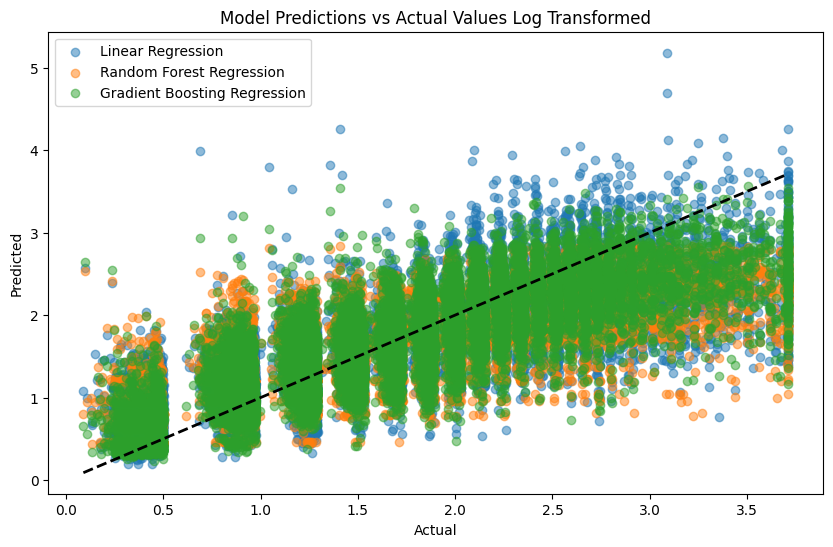

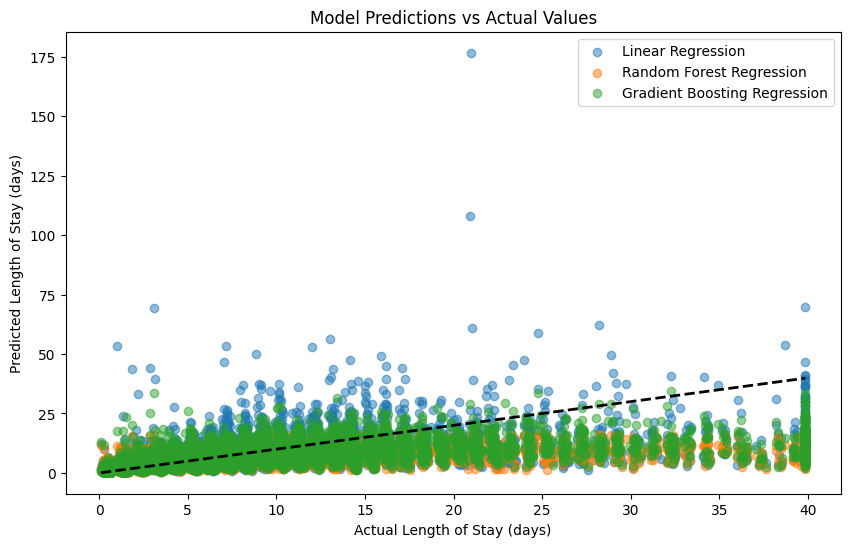

In [ ]:
# Display results

# Evaluate Linear Regression
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
print(f'Linear Regression MSE: {mse_linear:.3f}, R2: {r2_linear:.3f}')

# Evaluate Random Forest Regression
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'Random Forest Regression MSE: {mse_rf:.3f}, R2: {r2_rf:.3f}')

# Evaluate Gradient Boosting Regression
mse_gbm = mean_squared_error(y_test, y_pred_gbm)
r2_gbm = r2_score(y_test, y_pred_gbm)
print(f'Gradient Boosting Regression MSE: {mse_gbm:.3f}, R2: {r2_gbm:.3f}')

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_linear, label='Linear Regression', alpha=0.5)
plt.scatter(y_test, y_pred_rf, label='Random Forest Regression', alpha=0.5)
plt.scatter(y_test, y_pred_gbm, label='Gradient Boosting Regression', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.title('Model Predictions vs Actual Values Log Transformed')
plt.show()

# Convert log-transformed predictions back to original scale
y_pred_linear_original = np.expm1(y_pred_linear)
y_pred_rf_original = np.expm1(y_pred_rf)
y_pred_gbm_original = np.expm1(y_pred_gbm)
y_test_original = np.expm1(y_test)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_linear_original, label='Linear Regression', alpha=0.5)
plt.scatter(y_test_original, y_pred_rf_original, label='Random Forest Regression', alpha=0.5)
plt.scatter(y_test_original, y_pred_gbm_original, label='Gradient Boosting Regression', alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'k--', lw=2)
plt.xlabel('Actual Length of Stay (days)')
plt.ylabel('Predicted Length of Stay (days)')
plt.legend()
plt.title('Model Predictions vs Actual Values')
plt.show()

# Compare Regression Models
Compare model performance using regression metrics and visualize predictions vs actuals with scatter plots.

In [ ]:
# Create Regression Models

# Support Vector Regression Model
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(x_train_imputed, y_train)
y_pred_svr = svr_model.predict(x_test_imputed)

# Decision Tree Regression Model
dt_model = DecisionTreeRegressor(max_depth=5, random_state=1)
dt_model.fit(x_train_imputed, y_train)
y_pred_dt = dt_model.predict(x_test_imputed)

# K-Nearest Neighbors Regression Model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(x_train_imputed, y_train)
y_pred_knn = knn_model.predict(x_test_imputed)


Decision Tree Regression MSE: 0.191, R2: 0.601
Support Vector Regression MSE: 0.184, R2: 0.617
K-Nearest Neighbors Regression MSE: 0.170, R2: 0.645


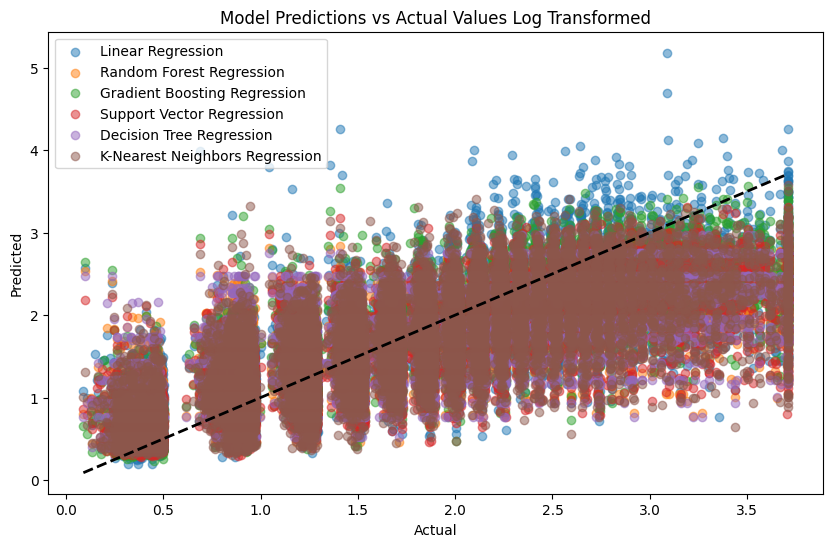

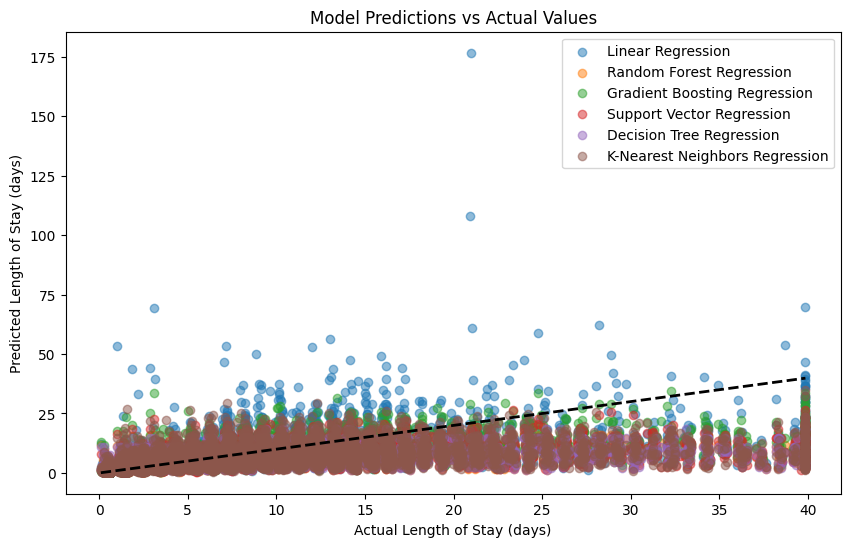

In [95]:
# Present Results of Regression Models 

# Evaluate Decision Tree Regression
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
print(f'Decision Tree Regression MSE: {mse_dt:.3f}, R2: {r2_dt:.3f}')

# Evaluate Support Vector Regression
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
print(f'Support Vector Regression MSE: {mse_svr:.3f}, R2: {r2_svr:.3f}')

# Evaluate K-Nearest Neighbors Regression
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
print(f'K-Nearest Neighbors Regression MSE: {mse_knn:.3f}, R2: {r2_knn:.3f}')

# Plotting the results - Log Transformed
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_linear, label='Linear Regression', alpha=0.5)
plt.scatter(y_test, y_pred_rf, label='Random Forest Regression', alpha=0.5)
plt.scatter(y_test, y_pred_gbm, label='Gradient Boosting Regression', alpha=0.5)
plt.scatter(y_test, y_pred_svr, label='Support Vector Regression', alpha=0.5)
plt.scatter(y_test, y_pred_dt, label='Decision Tree Regression', alpha=0.5)
plt.scatter(y_test, y_pred_knn, label='K-Nearest Neighbors Regression', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.title('Model Predictions vs Actual Values Log Transformed')
plt.show()

# Convert log-transformed predictions back to original scale
y_pred_dt_original = np.expm1(y_pred_dt)
y_pred_svr_original = np.expm1(y_pred_svr)
y_pred_knn_original = np.expm1(y_pred_knn)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_linear_original, label='Linear Regression', alpha=0.5)
plt.scatter(y_test_original, y_pred_rf_original, label='Random Forest Regression', alpha=0.5)
plt.scatter(y_test_original, y_pred_gbm_original, label='Gradient Boosting Regression', alpha=0.5)
plt.scatter(y_test_original, y_pred_svr_original, label='Support Vector Regression', alpha=0.5)
plt.scatter(y_test_original, y_pred_dt_original, label='Decision Tree Regression', alpha=0.5)
plt.scatter(y_test_original, y_pred_knn_original, label='K-Nearest Neighbors Regression', alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'k--', lw=2)
plt.xlabel('Actual Length of Stay (days)')
plt.ylabel('Predicted Length of Stay (days)')
plt.legend()
plt.title('Model Predictions vs Actual Values')
plt.show()

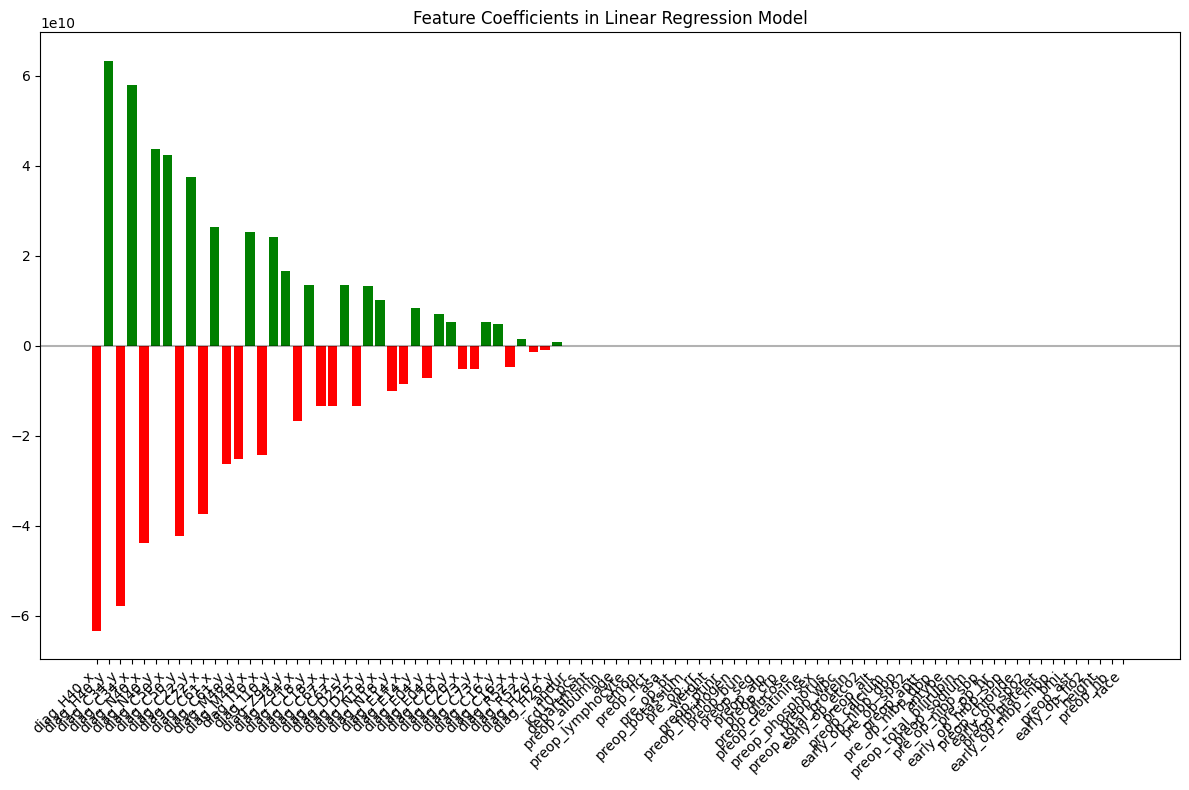


Top 10 Features Associated with Longer LOS:
       Feature   Coefficient
51  diag_H40_y  6.331422e+10
22  diag_C34_x  5.788606e+10
55  diag_N40_y  4.383553e+10
23  diag_C50_x  4.228433e+10
41  diag_C22_y  3.740958e+10
24  diag_C61_x  2.630782e+10
33  diag_M48_x  2.519843e+10
52  diag_I10_y  2.419007e+10
57  diag_Z94_y  1.667898e+10
39  diag_C18_y  1.346329e+10

Top 10 Features Associated with Shorter LOS:
       Feature   Coefficient
31  diag_H40_x -6.331422e+10
42  diag_C34_y -5.788606e+10
35  diag_N40_x -4.383553e+10
43  diag_C50_y -4.228433e+10
21  diag_C22_x -3.740958e+10
44  diag_C61_y -2.630782e+10
53  diag_M48_y -2.519843e+10
32  diag_I10_x -2.419007e+10
37  diag_Z94_x -1.667898e+10
19  diag_C18_x -1.346329e+10


In [90]:
# Scale features for interpretable coefficients
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_imputed)
linear_model.fit(x_train_scaled, y_train)

# Create coefficient DataFrame
coef_df = pd.DataFrame({
    'Feature': INPUT_VARS,
    'Coefficient': linear_model.coef_
})

# Sort by absolute coefficient value
coef_df['Abs_Coefficient'] = abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

# Plot coefficients
plt.figure(figsize=(12, 8))
colors = ['red' if c < 0 else 'green' for c in coef_df['Coefficient']]
plt.bar(range(len(coef_df)), coef_df['Coefficient'], color=colors)
plt.xticks(range(len(coef_df)), coef_df['Feature'], rotation=45, ha='right')
plt.title('Feature Coefficients in Linear Regression Model')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

# Print top 10 positive and negative coefficients
print("\nTop 10 Features Associated with Longer LOS:")
print(coef_df[coef_df['Coefficient'] > 0].head(10)[['Feature', 'Coefficient']])

print("\nTop 10 Features Associated with Shorter LOS:")
print(coef_df[coef_df['Coefficient'] < 0].head(10)[['Feature', 'Coefficient']])

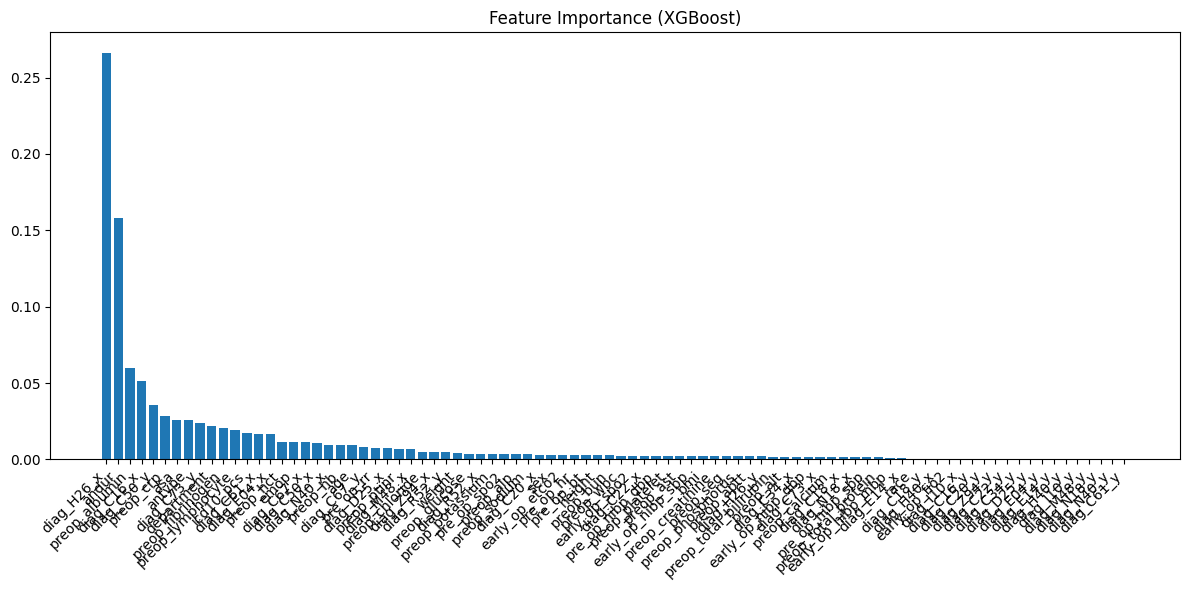


Top 10 Most Important Features:
          Feature  XGB_Importance
30     diag_H26_x        0.266363
4           andur        0.158326
12  preop_albumin        0.059878
18     diag_C16_x        0.051170
43     diag_C50_y        0.035424
73      preop_crp        0.028702
61            asa        0.025872
63         antype        0.025815
46     diag_C73_y        0.024109
62     department        0.022096


In [91]:
# Feature Importance Analysis

# Create a dataframe to store feature importances from different models
importance_df = pd.DataFrame({'Feature': INPUT_VARS})

# 1. Linear Regression - Get standardized coefficients
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_imputed)
linear_model.fit(x_train_scaled, y_train)
importance_df['Linear_Coef'] = np.abs(linear_model.coef_)

# 2. Random Forest - Built-in feature importance
importance_df['RF_Importance'] = rf_model.feature_importances_

# 3. XGBoost - Built-in feature importance
importance_df['XGB_Importance'] = gbm_model.feature_importances_

# Sort by XGBoost importance (generally most reliable)
importance_df = importance_df.sort_values('XGB_Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(len(importance_df)), importance_df['XGB_Importance'])
plt.xticks(range(len(importance_df)), importance_df['Feature'], rotation=45, ha='right')
plt.title('Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()

# Print top 10 most important features
print("\nTop 10 Most Important Features:")
print(importance_df[['Feature', 'XGB_Importance']].head(10))

Linear Regression MSE: 37.977, R2: -0.241
Random Forest Regression MSE: 29.386, R2: 0.040
Gradient Boosting Regression MSE: 29.794, R2: 0.027
Support Vector Regression MSE: 30.056, R2: 0.018
Decision Tree Regression MSE: 29.762, R2: 0.028
K-Nearest Neighbors Regression MSE: 32.027, R2: -0.046


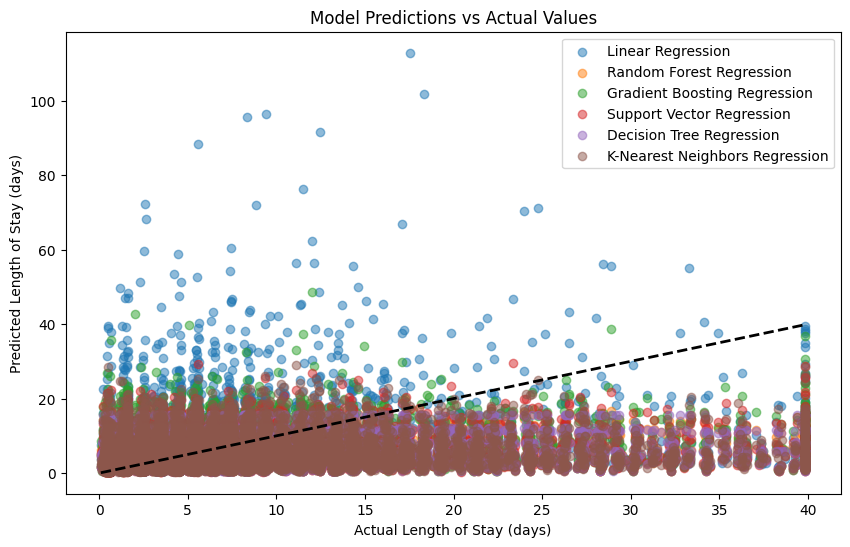

In [92]:
# Model Evaluation System - Fixed Version

# Function to evaluate models
def evaluate_model(y_true_log, y_pred_log, model_name):
    # First convert both true and predicted values back to original scale
    y_true_original = np.expm1(y_true_log)
    y_pred_original = np.expm1(y_pred_log)
    
    # Calculate metrics on original scale
    mse = mean_squared_error(y_true_original, y_pred_original)
    r2 = r2_score(y_true_original, y_pred_original)
    print(f'{model_name} MSE: {mse:.3f}, R2: {r2:.3f}')
    return mse, r2

# Store evaluation results
evaluation_results = {}

# Evaluate each model
for model_name, y_pred_log in models.items():
    mse, r2 = evaluate_model(y_test, y_pred_log, model_name)
    evaluation_results[model_name] = {'MSE': mse, 'R2': r2}

# Plotting the results
plt.figure(figsize=(10, 6))
for model_name, y_pred_log in models.items():
    y_pred_original = np.expm1(y_pred_log)
    plt.scatter(np.expm1(y_test), y_pred_original, label=model_name, alpha=0.5)

plt.plot([np.expm1(y_test).min(), np.expm1(y_test).max()], 
         [np.expm1(y_test).min(), np.expm1(y_test).max()], 
         'k--', lw=2)
plt.xlabel('Actual Length of Stay (days)')
plt.ylabel('Predicted Length of Stay (days)')
plt.legend()
plt.title('Model Predictions vs Actual Values')
plt.show()